In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_thrust(speeds, k):
    return k * speeds**2

def get_rotation_matrix(angles):
    phi, theta, psi = angles
    Ry =  np.array([[np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)]])

    Rx =  np.array([[1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)]])

    Rz =  np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

    return (Rz @ Ry @ Rx)

def get_F(speeds, k, g, m, angle):
    R = get_rotation_matrix(angle)
    T_b = np.array([0, 0, sum(get_thrust(speeds, k))])
    Fg = np.array([0, 0, m*g])
    return Fg + R @ T_b

def get_angular_transformation(angles, omegas):
    phi, theta, psi = angles
    phi_dot, theta_dot, psi_dot = omegas
    W = np.array([[1, 0, -np.sin(theta)], #Transformation matrix for angular velocities from body frame to inertial frame
                  [0, np.cos(phi), np.cos(phi) * np.sin(phi)],
                  [0, -np.sin(phi), np.cos(theta) * np.cos(phi)]])
    dWdt = np.array([[0, phi_dot * np.cos(phi) * np.tan(theta) + theta_dot * np.sin(phi) / np.cos(theta)**2, -phi_dot * np.sin(phi) * np.cos(phi) + theta_dot * np.cos(phi) / np.cos(theta)**2],
                     [0, -phi_dot * np.sin(phi), -phi_dot * np.cos(phi)],
                     [0, phi_dot * np.cos(phi) / np.cos(theta) + phi_dot * np.sin(phi) * np.tan(theta) / np.cos(theta), -phi_dot * np.sin(phi) / np.cos(theta) + theta_dot * np.cos(phi) * np.tan(theta) / np.cos(theta)]])
    W_inv = np.linalg.inv(W)
    return [W, dWdt, W_inv]

def get_torque(speeds, k, l, b):
    Ti = get_thrust(speeds, k)
    tau_phi = l * (Ti[3] - Ti[1])
    tau_theta = l * (Ti[2] - Ti[0])
    tau_psi = 0
    for omega in speeds:
        if omega < 0:
            tau_psi += -b * omega**2
        else:
            tau_psi += b * omega**2
    return np.array([tau_phi, tau_theta, tau_psi])

def get_alpha(speeds, k, l, b, I, omega, angle):
    Ixx, Iyy, Izz = I
    torque = get_torque(speeds,  k, l, b)

    # W, dWdt, W_inv = get_angular_transformation(angle, omega)
    # eta = W @ omega
    omegax, omegay, omegaz = omega
    alpha = np.array([(torque[0] - (Iyy - Izz)*omegay*omegaz) / Ixx, (torque[1] - (Izz - Ixx)*omegax*omegaz) / Iyy, (torque[2] - (Ixx - Iyy)*omegax*omegay) / Izz])
    return alpha
 
def speed_function(t):
    # constant speed
    omega = 2429.5 #rad/s, 23000 rpm
    # return np.array([omega, -omega, omega, -omega])
    
    # varying speed
    return omega * np.array([0.5, -2, 1, -1])

C:\Users\Ray\AppData\Local\Temp\ipykernel_20260\31375003.py:57: RuntimeWarning: overflow encountered in scalar multiply
  alpha = np.array([(torque[0] - (Iyy - Izz)*omegay*omegaz) / Ixx, (torque[1] - (Izz - Ixx)*omegax*omegaz) / Iyy, (torque[2] - (Ixx - Iyy)*omegax*omegay) / Izz])
C:\Users\Ray\AppData\Local\Temp\ipykernel_20260\370794677.py:32: RuntimeWarning: invalid value encountered in add
  omega_range[i] = omega_range[i-1] + dt * alpha
C:\Users\Ray\AppData\Local\Temp\ipykernel_20260\31375003.py:6: RuntimeWarning: invalid value encountered in cos
  Ry =  np.array([[np.cos(theta), 0, np.sin(theta)],
C:\Users\Ray\AppData\Local\Temp\ipykernel_20260\31375003.py:6: RuntimeWarning: invalid value encountered in sin
  Ry =  np.array([[np.cos(theta), 0, np.sin(theta)],
C:\Users\Ray\AppData\Local\Temp\ipykernel_20260\31375003.py:8: RuntimeWarning: invalid value encountered in sin
  [-np.sin(theta), 0, np.cos(theta)]])
C:\Users\Ray\AppData\Local\Temp\ipykernel_20260\31375003.py:8: RuntimeWarn

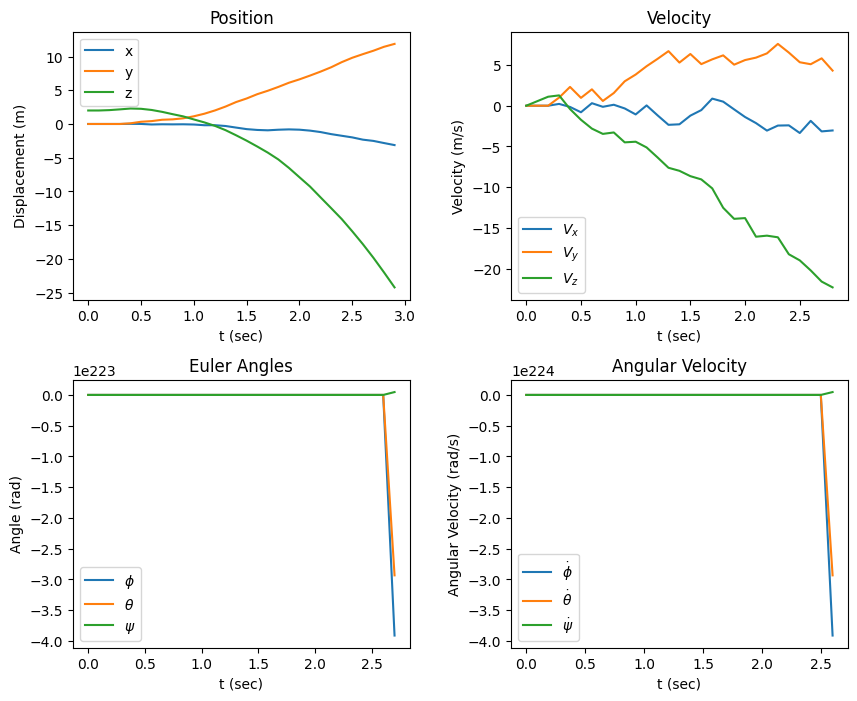

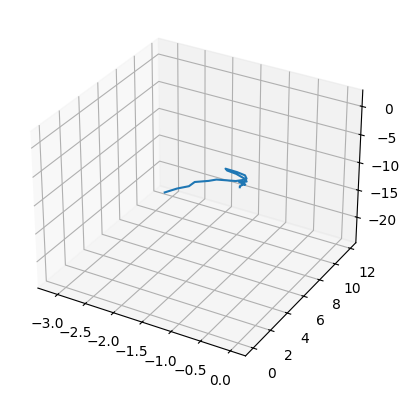

In [3]:
m = 0.139 # kg
g = -9.8 #m/s^2
Ixx = 0.00101954 #Rotational inertia about the X axis 
Iyy = 0.000998 #Rotational inertia about the Y axis 
Izz = 0.002 #Rotational inertia about the Z axis 
k = 5.7696182373812049285635958944478e-8 #Thrust Coefficient
b = 1e-10 #Torque Coeffiecient
l = np.sqrt(50) / 100 #arm length

I = np.array([Ixx, Iyy, Izz]) #rotational inertia matrix

dt = 0.1 #s
T = 120 #s
N = int(T / dt) # number of steps

r_range = np.zeros((N, 3))
r_range[0][2] = 2
v_range = np.zeros((N, 3))
angle_range = np.zeros((N, 3))
omega_range = np.zeros((N, 3))
t_range = np.linspace(0, T, N+1)[:-1]

for i in range(1, N):
    speeds = speed_function(i * dt) #speed of each motor in rpm

    a = get_F(speeds, k, g, m, angle_range[i-1]) / m
    alpha = get_alpha(speeds, k, l, b, I, omega_range[i-1], angle_range[i-1])
    # print(alpha)
    r_range[i] = r_range[i-1] + dt * v_range[i-1]
    v_range[i] = v_range[i-1] + dt * a
    angle_range[i] = angle_range[i-1] + dt * omega_range[i-1]
    omega_range[i] = omega_range[i-1] + dt * alpha

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax[0,0].plot(t_range, r_range[:,0], label=r"x")
ax[0,0].plot(t_range, r_range[:,1], label=r"y")
ax[0,0].plot(t_range, r_range[:,2], label=r"z")
ax[0,0].set_xlabel("t (sec)")
ax[0,0].set_ylabel("Displacement (m)")
ax[0,0].set_title("Position")
ax[0,0].legend()

ax[0,1].plot(t_range, v_range[:,0], label=r"$V_x$")
ax[0,1].plot(t_range, v_range[:,1], label=r"$V_y$")
ax[0,1].plot(t_range, v_range[:,2], label=r"$V_z$")
ax[0,1].set_xlabel("t (sec)")
ax[0,1].set_ylabel("Velocity (m/s)")
ax[0,1].set_title("Velocity")
ax[0,1].legend()

ax[1,0].plot(t_range, angle_range[:,0], label=r"$\phi$")
ax[1,0].plot(t_range, angle_range[:,1], label=r"$\theta$")
ax[1,0].plot(t_range, angle_range[:,2], label=r"$\psi$")
ax[1,0].set_xlabel("t (sec)")
ax[1,0].set_ylabel("Angle (rad)")
ax[1,0].set_title("Euler Angles")
ax[1,0].legend()

ax[1,1].plot(t_range, omega_range[:,0], label=r"$\dot \phi$")
ax[1,1].plot(t_range, omega_range[:,1], label=r"$\dot \theta$")
ax[1,1].plot(t_range, omega_range[:,2], label=r"$\dot \psi$")
ax[1,1].set_xlabel("t (sec)")
ax[1,1].set_ylabel("Angular Velocity (rad/s)")
ax[1,1].set_title("Angular Velocity")
ax[1,1].legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r_range[:,0], r_range[:,1], r_range[:,2])